In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import welch
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import warnings
import time # Import time module for complexity measurement
import pickle # For loading .pkl dataset

# Suppress specific warnings for cleaner output in Kaggle Notebooks
warnings.filterwarnings("ignore", category=UserWarning, module="seaborn")
warnings.filterwarnings("ignore", category=FutureWarning)

# --- 1. Data Loading (RadioML Dataset) ---
# This section defines the function for loading the specified RadioML dataset.
# It extracts I/Q samples, modulation types, and SNRs, and filters for analog modulations.
# This version is specifically adapted for RML2016.10a_dict.pkl.
#
# Future Enhancements:
# - Implement more robust error handling for file loading and data parsing.
# - Add options to load specific subsets of the dataset (e.g., only certain SNRs).
# - Consider memory efficiency for very large datasets (e.g., lazy loading).
# - Expand the mapping to include other analog modulation types if relevant to your study.
#
# Troubleshooting Tips:
# - Ensure the `data_path` is correct and the dataset is accessible in your Kaggle environment.
# - Verify the structure of the .pkl file if loading fails (e.g., ensure it's a dictionary with (mod_type_string, SNR_value) keys).
# - If filtering for analog modulations results in empty data, check the exact modulation names
#   present in the dataset (e.g., 'AM-DSB' vs 'AM').
# - For RML2016.10a, note that a true 'PM' (analog Phase Modulation) class is not present;
#   only 'AM' (including AM-DSB, AM-SSB) and 'FM' (WBFM) are typically considered analog.


In [ ]:
def load_radioml_pkl_dataset(data_path):
    """
    Loads the RadioML 2016.10a dataset from a .pkl file and filters for analog modulations.
    Returns data in a dictionary format: {(modulation_type, SNR_dB): [list_of_complex_signals]}
    """
    print(f"Loading RadioML 2016.10a dataset from: {data_path}")
    with open(data_path, 'rb') as f:
        # Use encoding='latin1' for compatibility with Python 2 pickles
        Xd = pickle.load(f, encoding='latin1') 
    
    radioml_dict = {}
    filtered_labels = set()
    filtered_snrs = set()
    
    # Define the analog modulations we are interested in and their mapping to simplified names
    # These are the actual string names found in the dataset keys (key[0]).
    analog_mod_map = {
        'AM-DSB': 'AM',
        'WBFM': 'FM',
        'AM-SSB': 'AM', # Map AM-SSB to 'AM' for simplified analog classification
    }
    
    # Collect all raw modulation names (strings) found in dataset for debugging
    all_raw_mod_names_strings = set()

    # Xd keys are typically (modulation_name_string, SNR_value) tuples for RML2016.10a_dict.pkl
    for key, val in Xd.items():
        mod_name_raw = key[0] # This is the string name for RML2016.10a_dict.pkl
        snr_db = key[1]      # This is the SNR value
        
        all_raw_mod_names_strings.add(mod_name_raw) # Collect all raw names (strings) for debugging
        
        # Check if it's one of our target analog modulations
        if mod_name_raw in analog_mod_map:
            simplified_mod_name = analog_mod_map[mod_name_raw]
            
            signals_list = []
            # 'val' is a numpy array of shape (num_examples, 2, num_samples)
            for i in range(val.shape[0]):
                # Convert IQ samples to complex numbers (I + jQ)
                complex_signal = val[i, 0, :] + 1j * val[i, 1, :]
                signals_list.append(complex_signal)
            
            # Aggregate signals by simplified mod name and SNR
            current_key = (simplified_mod_name, snr_db)
            if current_key not in radioml_dict:
                radioml_dict[current_key] = []
            radioml_dict[current_key].extend(signals_list)
            
            filtered_labels.add(simplified_mod_name)
            filtered_snrs.add(snr_db)
            
    unique_snrs_found = sorted(list(filtered_snrs))
    unique_mods_found = sorted(list(filtered_labels))
    
    # DEBUG PRINT: This will show you the exact modulation names (strings) found in the dataset.
    print(f"DEBUG: All raw modulation names (strings) found in dataset: {all_raw_mod_names_strings}") 
    print(f"Loaded dataset contains: {len(unique_mods_found)} analog modulations and {len(unique_snrs_found)} SNRs.")
    
    # Print counts for each (mod_type, SNR) combination found
    # Use the actual keys from radioml_dict for accurate counts
    for key in sorted(radioml_dict.keys()): # Sort keys for consistent output order
        mod_type = key[0]
        snr_val = key[1]
        print(f"  Found {len(radioml_dict[key])} {mod_type} signals at {snr_val} dB SNR.")

    print("RadioML dataset loading and filtering complete.")
    return radioml_dict, unique_mods_found, unique_snrs_found

# --- 2. Feature Extraction ---
# This section defines the `extract_analog_features` function, which computes
# statistical features from the instantaneous amplitude, phase, and frequency of signals.
# These features are crucial for distinguishing between different analog modulation types.
#
# Future Enhancements:
# - Implement more advanced feature extraction techniques (e.g., Higher-Order Cumulants (HOCs),
#   cyclostationary features, wavelet transform coefficients).
# - Explore feature selection methods (e.g., PCA, correlation analysis) to reduce dimensionality
#   and improve classifier performance/speed.
# - Optimize feature calculation for large datasets (e.g., using Numba or C extensions).
#
# Troubleshooting Tips:
# - If classification accuracy is low, re-evaluate the discriminative power of features.
#   Plotting feature distributions (as done later) can help identify non-discriminative features.
# - Check for numerical stability issues (e.g., division by zero, NaN values) in feature calculations,
#   especially with low-power or noisy signals.
# - Ensure `fs` (sampling frequency) is correctly passed and used in instantaneous frequency calculation.


In [ ]:
def extract_analog_features(signal, fs=128): # Updated default fs to 128 for RML2016.10a
    """
    Extracts basic instantaneous features from a complex signal.
    For a real project, you'd add more sophisticated features like:
    - Higher-Order Cumulants (HOCs)
    - Spectral features (e.g., bandwidth, spectral symmetry from PSD)
    - Cyclostationary features
    """
    # Instantaneous Amplitude
    amplitude = np.abs(signal)
    
    # Instantaneous Phase (unwrapped)
    phase = np.unwrap(np.angle(signal))
    
    # Instantaneous Frequency (derivative of unwrapped phase)
    # Avoid division by zero if fs is not provided or is 0
    if fs == 0:
        # Default to a small non-zero value or handle as error
        print("Warning: Sampling frequency (fs) is 0, cannot calculate instantaneous frequency accurately. Using placeholder.")
        instantaneous_frequency = np.zeros_like(phase) # Placeholder
    else:
        instantaneous_frequency = np.diff(phase) / (2 * np.pi) * fs
        # Pad with a zero to match original signal length for consistency
        instantaneous_frequency = np.pad(instantaneous_frequency, (0, 1), 'constant')

    # Basic statistics
    # Add a small epsilon to standard deviation to prevent division by zero for constant signals
    std_amp = np.std(amplitude)
    std_freq = np.std(instantaneous_frequency)

    features = {
        'amp_mean': np.mean(amplitude),
        'amp_variance': np.var(amplitude),
        'amp_skewness': np.mean((amplitude - np.mean(amplitude))**3) / (std_amp**3 + 1e-9) if std_amp > 1e-9 else 0,
        'amp_kurtosis': np.mean((amplitude - np.mean(amplitude))**4) / (std_amp**4 + 1e-9) - 3 if std_amp > 1e-9 else -3, # Excess kurtosis
        'freq_mean': np.mean(instantaneous_frequency),
        'freq_variance': np.var(instantaneous_frequency),
        'freq_skewness': np.mean((instantaneous_frequency - np.mean(instantaneous_frequency))**3) / (std_freq**3 + 1e-9) if std_freq > 1e-9 else 0,
        'freq_kurtosis': np.mean((instantaneous_frequency - np.mean(instantaneous_frequency))**4) / (std_freq**4 + 1e-9) - 3 if std_freq > 1e-9 else -3,
    }
    return features

# --- 3. Plotting Functions ---
# This section contains helper functions for generating various visualizations,
# including time-domain waveforms, power spectral density, feature distributions,
# confusion matrices, and accuracy vs. SNR plots.
#
# Future Enhancements:
# - Add more interactive plots (e.g., using Plotly or Bokeh) for deeper data exploration.
# - Implement custom styling or themes for plots to match publication requirements.
# - Add functionality to save plots automatically to specific directories.
# - Include other relevant visualization types (e.g., t-SNE or UMAP for feature space visualization).
#
# Troubleshooting Tips:
# - If plots are empty or show unexpected values, verify the input data to the plotting function.
# - Check `num_samples_to_plot` for time-domain plots to ensure a visible segment.
# - For PSD plots, ensure `fs` and `nperseg` are appropriate for your signal.
# - If Seaborn plots are slow, consider sampling a smaller subset of data for visualization.

In [ ]:
def plot_time_domain_waveform(signal, title="Time Domain Waveform (I/Q)", num_samples_to_plot=128): # Updated default num_samples_to_plot
    """Plots the I and Q components of a complex signal in the time domain."""
    plt.figure(figsize=(10, 4))
    t = np.linspace(0, len(signal)/128, len(signal), endpoint=False) # Assuming 128 samples/sec for RML2016.10a
    plt.plot(t[:num_samples_to_plot], signal.real[:num_samples_to_plot], label='In-phase (I)')
    plt.plot(t[:num_samples_to_plot], signal.imag[:num_samples_to_plot], label='Quadrature (Q)', linestyle='--')
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_power_spectral_density(signal, fs=128, title="Power Spectral Density"): # Updated default fs to 128
    """Plots the Power Spectral Density (PSD) of a complex signal."""
    plt.figure(figsize=(10, 4))
    # nperseg should be less than or equal to the number of samples
    nperseg_val = min(len(signal), 64) # Adjusted segment length for 128 samples
    f, Pxx_den = welch(signal, fs, nperseg=nperseg_val) 
    plt.semilogy(f, Pxx_den)
    plt.title(title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power/Frequency (dB/Hz)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_feature_distributions(dataframe, feature_name, title="Feature Distribution"):
    """Plots the distribution of a specific feature for different modulation types."""
    plt.figure(figsize=(8, 5))
    sns.histplot(data=dataframe, x=feature_name, hue='Modulation', kde=True, palette='viridis')
    plt.title(title)
    plt.xlabel(feature_name)
    plt.ylabel('Density / Count')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    """Plots a confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=.5, linecolor='black')
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

def plot_accuracy_vs_snr(snr_values, dt_accuracy, knn_accuracy, baseline_accuracy, title='Classification Accuracy vs. SNR'):
    """Plots accuracy curves for different classifiers against SNR."""
    plt.figure(figsize=(10, 6))
    plt.plot(snr_values, baseline_accuracy, marker='o', linestyle='--', label='Baseline')
    plt.plot(snr_values, dt_accuracy, marker='x', linestyle='-', label='Decision Tree')
    plt.plot(snr_values, knn_accuracy, marker='s', linestyle='-', label='KNN') # Changed SVM to KNN
    
    plt.title(title)
    plt.xlabel('SNR (dB)')
    plt.ylabel('Accuracy (%)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.ylim(0, 105)
    plt.xticks(snr_values)
    plt.tight_layout()
    plt.show()

# --- 4. Main Execution Block ---
# This is the primary execution flow of the script. It orchestrates the entire AMC process:
# data simulation, feature extraction, model training, performance evaluation, and visualization.
#
# Future Enhancements:
# - Implement hyperparameter tuning (e.g., GridSearchCV, RandomizedSearchCV) for DT and KNN
#   to find optimal model parameters, potentially improving accuracy.
# - Add cross-validation techniques (e.g., K-fold cross-validation) for more robust model evaluation.
# - Incorporate model persistence (saving/loading trained models) for reusability.
# - Extend to include other traditional ML classifiers (e.g., Random Forest, Naive Bayes, SVM).
# - Integrate with actual RadioML dataset loading when available.
#
# Troubleshooting Tips:
# - If the script crashes, check the console output for specific error messages and line numbers.
# - Verify data shapes and types at each stage (e.g., before splitting, before model training).
# - If accuracies are unexpectedly low, re-check feature extraction logic and ensure data splitting
#   is correct (e.g., `stratify=y` is important for imbalanced datasets).
# - For performance issues, consider reducing `num_signals_per_mod_snr` or `num_samples_per_signal`
#   during initial development/debugging.

Loading RadioML 2016.10a dataset from: /kaggle/input/radioml2016-deepsigcom/RML2016.10a_dict.pkl
DEBUG: All raw modulation names (strings) found in dataset: {'QAM64', 'BPSK', 'WBFM', 'PAM4', 'CPFSK', 'GFSK', 'AM-SSB', 'QAM16', '8PSK', 'QPSK', 'AM-DSB'}
Loaded dataset contains: 2 analog modulations and 20 SNRs.
  Found 2000 AM signals at -20 dB SNR.
  Found 2000 AM signals at -18 dB SNR.
  Found 2000 AM signals at -16 dB SNR.
  Found 2000 AM signals at -14 dB SNR.
  Found 2000 AM signals at -12 dB SNR.
  Found 2000 AM signals at -10 dB SNR.
  Found 2000 AM signals at -8 dB SNR.
  Found 2000 AM signals at -6 dB SNR.
  Found 2000 AM signals at -4 dB SNR.
  Found 2000 AM signals at -2 dB SNR.
  Found 2000 AM signals at 0 dB SNR.
  Found 2000 AM signals at 2 dB SNR.
  Found 2000 AM signals at 4 dB SNR.
  Found 2000 AM signals at 6 dB SNR.
  Found 2000 AM signals at 8 dB SNR.
  Found 2000 AM signals at 10 dB SNR.
  Found 2000 AM signals at 12 dB SNR.
  Found 2000 AM signals at 14 dB SNR.
  F

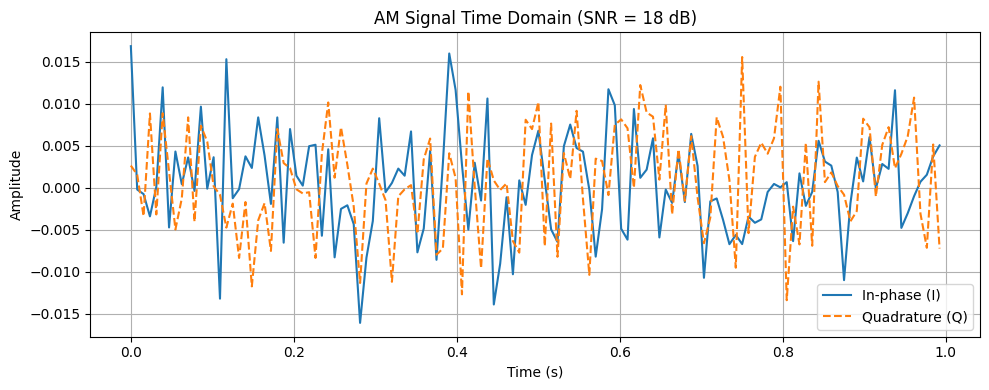

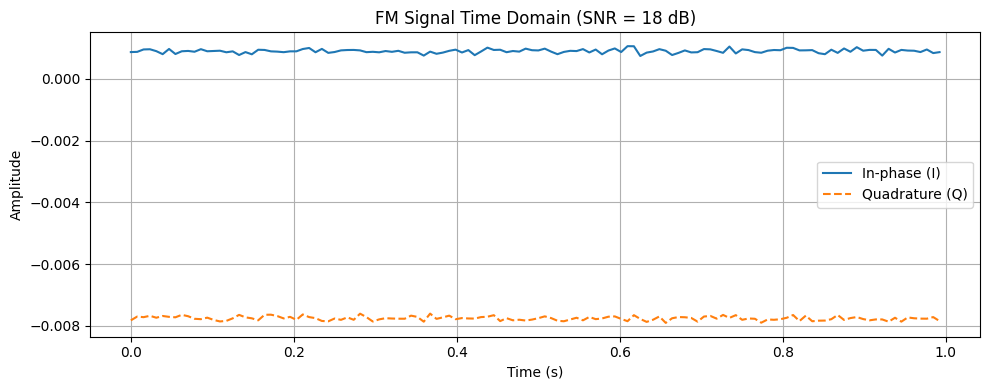

PM signal not available for time domain plot (Analog PM is not a class in RML2016.10a).

Plotting Power Spectral Density (PSD)...


/usr/local/lib/python3.11/dist-packages/scipy/signal/_spectral_py.py:652: UserWarning: Input data is complex, switching to return_onesided=False
  freqs, Pxx = csd(x, x, fs=fs, window=window, nperseg=nperseg,


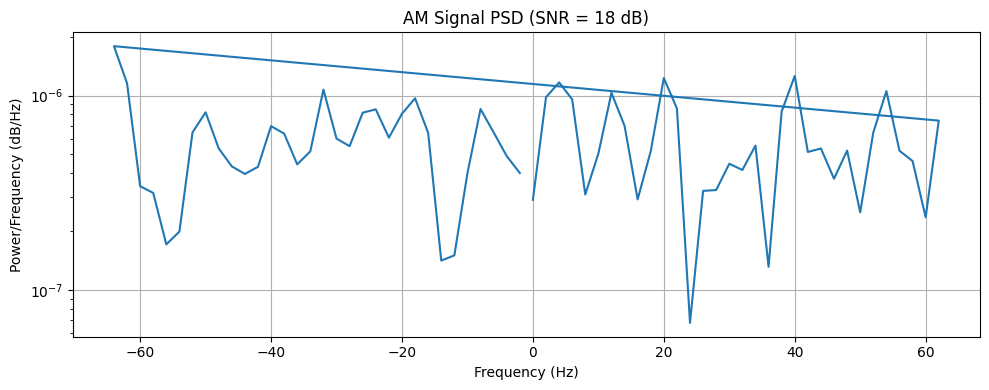

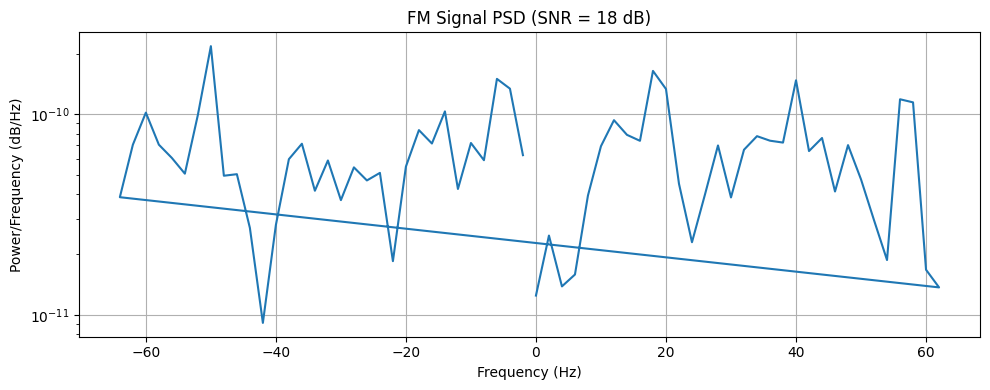

PM signal not available for PSD plot (Analog PM is not a class in RML2016.10a).

Extracting features and preparing data for ML models...
Training data shape: (42000, 8)
Testing data shape: (18000, 8)

Training Decision Tree (DT) model...
Decision Tree Overall Accuracy: 62.79%

Training K-Nearest Neighbors (KNN) model...
K-Nearest Neighbors Overall Accuracy: 65.82%

Plotting Feature Distributions (from a subset of data)...


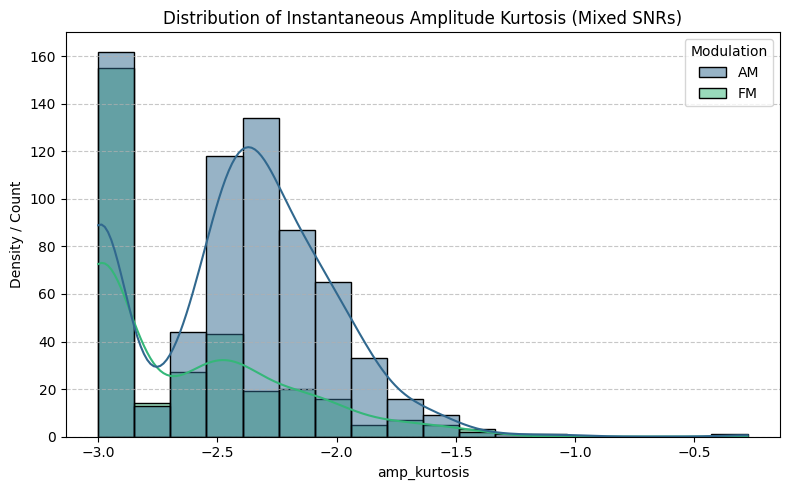

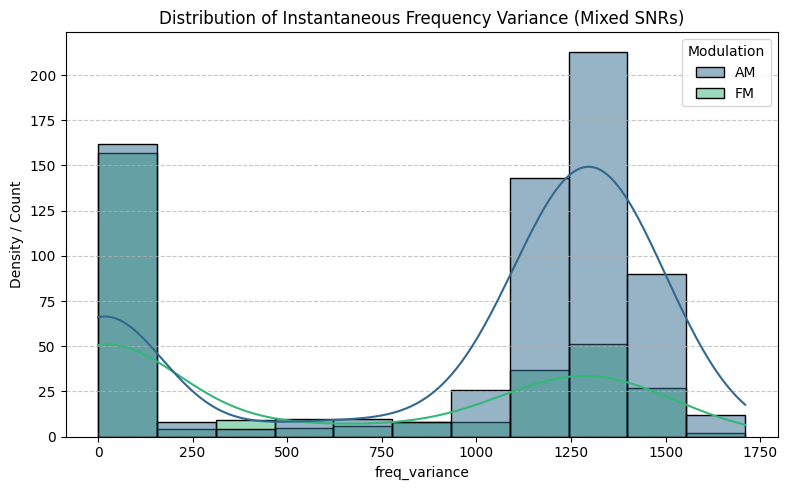


Calculating Accuracy vs. SNR for DT and KNN...

Table 1: Test Accuracy of Baseline and Proposed Methods (DT, KNN) across various SNRs
|   SNR (dB) |   Baseline Accuracy (%) |   Decision Tree Accuracy (%) |   KNN Accuracy (%) |
|-----------:|------------------------:|-----------------------------:|-------------------:|
|        -20 |                      50 |                        60.02 |              63.46 |
|        -18 |                      50 |                        61.01 |              64.58 |
|        -16 |                      50 |                        58.49 |              66.27 |
|        -14 |                      50 |                        60.2  |              65.65 |
|        -12 |                      50 |                        59.36 |              61.56 |
|        -10 |                      50 |                        62.09 |              66.23 |
|         -8 |                      50 |                        61.14 |              64.81 |
|         -6 |              

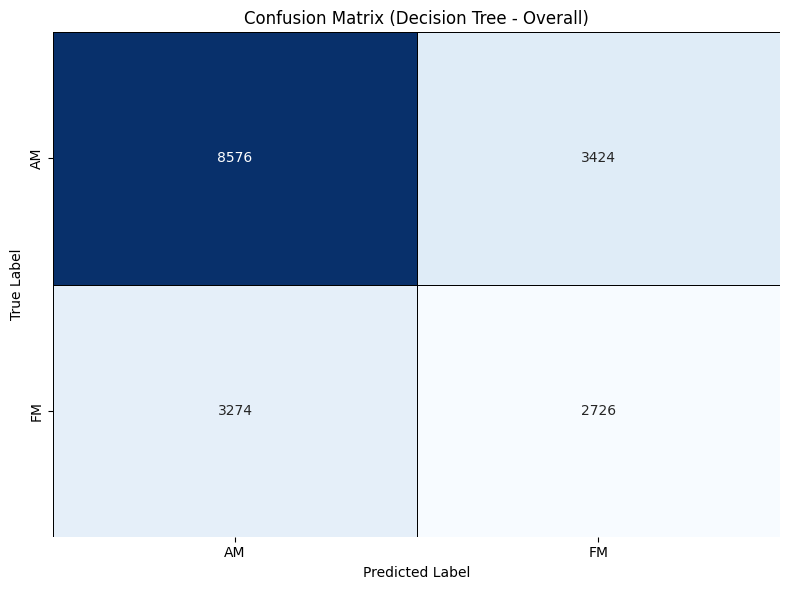


Plotting Confusion Matrix for K-Nearest Neighbors (Overall Test Set)...


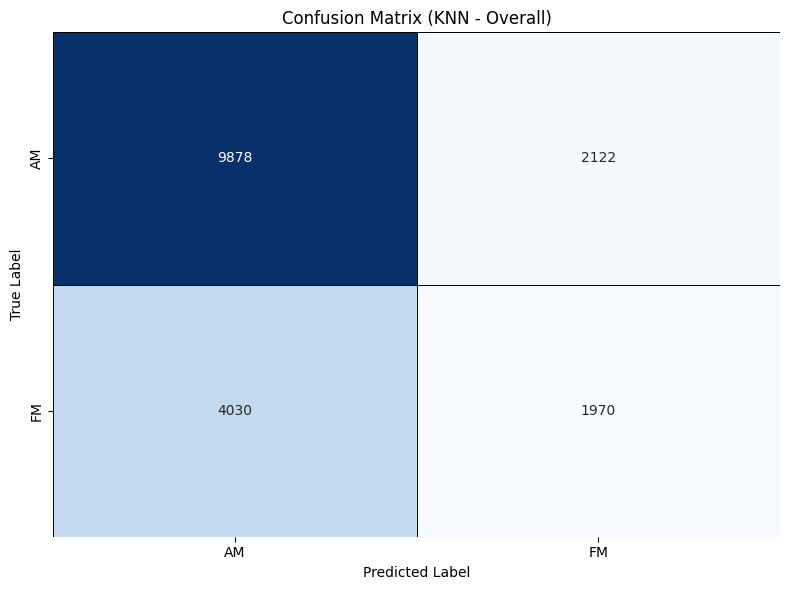


Plotting Accuracy vs. SNR curves...


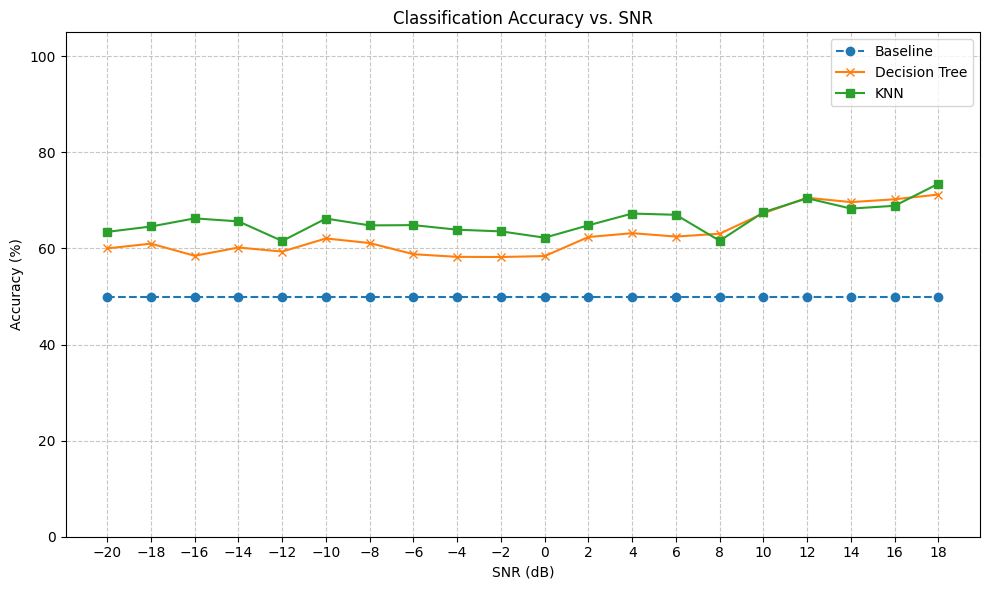


All simulations, training, plots, and tables generated successfully!


In [3]:
if __name__ == "__main__":
    # Path to the RadioML dataset on Kaggle
    # IMPORTANT: Ensure 'radioml2016-deepsigcom' is added as an input dataset in your Kaggle notebook.
    data_path = '/kaggle/input/radioml2016-deepsigcom/RML2016.10a_dict.pkl' 
    
    # Parameters for signal processing
    # RML2016.10a has 128 IQ samples per signal
    num_samples_per_signal = 128 

    # --- Load RadioML Dataset ---
    # Call the new pickle loading function
    radioml_data, unique_mod_types_in_data, unique_snr_values_in_data = load_radioml_pkl_dataset(data_path)

    # Use the actual SNRs found in the loaded data for evaluation
    snr_values = np.array(unique_snr_values_in_data)
    
    # --- Sample signals for initial visualization (High SNR for clarity) ---
    # Retrieve a high SNR signal for clear visualization
    # Ensure high_snr_val is actually present in the loaded data
    if unique_snr_values_in_data:
        high_snr_val = unique_snr_values_in_data[-1] # Use the highest SNR found
    else:
        # Fallback if no SNRs found (shouldn't happen with valid RML data after fix)
        high_snr_val = 18 
        print("Warning: No SNRs found in the loaded dataset. Using default high_snr_val for plotting.")

    # Try to get a sample signal for each type at high SNR
    # Note: RML2016.10a maps AM-DSB and AM-SSB to 'AM', and WBFM to 'FM'. It does not have 'PM'.
    am_signal_high_snr = radioml_data.get(('AM', high_snr_val), [None])[0]
    fm_signal_high_snr = radioml_data.get(('FM', high_snr_val), [None])[0]
    pm_signal_high_snr = None # Explicitly set to None as analog PM is not in RML2016.10a

    # --- Plot Time-Domain Waveforms ---
    print("\nPlotting Time-Domain Waveforms...")
    if am_signal_high_snr is not None:
        plot_time_domain_waveform(am_signal_high_snr, title=f"AM Signal Time Domain (SNR = {high_snr_val} dB)", num_samples_to_plot=num_samples_per_signal)
    else:
        print("AM signal not available for time domain plot.")
    if fm_signal_high_snr is not None:
        plot_time_domain_waveform(fm_signal_high_snr, title=f"FM Signal Time Domain (SNR = {high_snr_val} dB)", num_samples_to_plot=num_samples_per_signal)
    else:
        print("FM signal not available for time domain plot.")
    if pm_signal_high_snr is not None:
        plot_time_domain_waveform(pm_signal_high_snr, title=f"PM Signal Time Domain (SNR = {high_snr_val} dB)", num_samples_to_plot=num_samples_per_signal)
    else:
        print("PM signal not available for time domain plot (Analog PM is not a class in RML2016.10a).")


    # --- Plot Power Spectral Density (PSD) ---
    print("\nPlotting Power Spectral Density (PSD)...")
    if am_signal_high_snr is not None:
        plot_power_spectral_density(am_signal_high_snr, title=f"AM Signal PSD (SNR = {high_snr_val} dB)", fs=num_samples_per_signal)
    else:
        print("AM signal not available for PSD plot.")
    if fm_signal_high_snr is not None:
        plot_power_spectral_density(fm_signal_high_snr, title=f"FM Signal PSD (SNR = {high_snr_val} dB)", fs=num_samples_per_signal)
    else:
        print("FM signal not available for PSD plot.")
    if pm_signal_high_snr is not None:
        plot_power_spectral_density(pm_signal_high_snr, title=f"PM Signal PSD (SNR = {high_snr_val} dB)", fs=num_samples_per_signal)
    else:
        print("PM signal not available for PSD plot (Analog PM is not a class in RML2016.10a).")


    # --- Feature Extraction and Data Preparation for ML ---
    print("\nExtracting features and preparing data for ML models...")
    all_features_list = []
    all_labels = []
    all_snrs = [] # Keep track of SNRs for per-SNR accuracy evaluation

    for (mod_type, snr_db), signals_list in radioml_data.items():
        for signal in signals_list:
            features = extract_analog_features(signal, fs=num_samples_per_signal)
            all_features_list.append(list(features.values())) # Convert dict values to list for DataFrame
            all_labels.append(mod_type)
            all_snrs.append(snr_db)

    # Convert to DataFrame
    feature_names = list(extract_analog_features(np.zeros(num_samples_per_signal)).keys())
    features_df_ml = pd.DataFrame(all_features_list, columns=feature_names)
    labels_series = pd.Series(all_labels, name='Modulation')
    snrs_series = pd.Series(all_snrs, name='SNR')

    # Combine features, labels, and SNRs for splitting
    full_data_df = pd.concat([features_df_ml, labels_series, snrs_series], axis=1)

    # Split data into training and testing sets (stratified by modulation type)
    X = full_data_df[feature_names]
    y = full_data_df['Modulation']
    snr_info = full_data_df['SNR'] # Keep SNR info for evaluation

    # Check if there's enough data to split
    if len(X) == 0:
        print("\nERROR: No data loaded for analog modulations. Cannot perform train/test split or model training.")
        print("Please check the 'analog_mod_map' in load_radioml_pkl_dataset function and ensure it matches the dataset's modulation names.")
        # Exit or handle gracefully if no data
        exit() # Or raise an exception
    
    X_train, X_test, y_train, y_test, snr_train, snr_test = train_test_split(
        X, y, snr_info, test_size=0.3, random_state=42, stratify=y
    )
    
    print(f"Training data shape: {X_train.shape}")
    print(f"Testing data shape: {X_test.shape}")

    # --- Train Decision Tree (DT) Model ---
    print("\nTraining Decision Tree (DT) model...")
    start_time_dt_train = time.time()
    dt_model = DecisionTreeClassifier(random_state=42)
    dt_model.fit(X_train, y_train)
    end_time_dt_train = time.time()
    train_time_dt = end_time_dt_train - start_time_dt_train

    start_time_dt_inference = time.time()
    y_pred_dt = dt_model.predict(X_test)
    end_time_dt_inference = time.time()
    # Average inference time per sample (ms)
    inference_time_dt_ms_per_sample = ((end_time_dt_inference - start_time_dt_inference) / len(X_test)) * 1000

    overall_accuracy_dt = accuracy_score(y_test, y_pred_dt) * 100
    print(f"Decision Tree Overall Accuracy: {overall_accuracy_dt:.2f}%")

    # --- Train K-Nearest Neighbors (KNN) Model ---
    print("\nTraining K-Nearest Neighbors (KNN) model...")
    start_time_knn_train = time.time()
    # You might tune n_neighbors for optimal performance
    knn_model = KNeighborsClassifier(n_neighbors=5) 
    knn_model.fit(X_train, y_train)
    end_time_knn_train = time.time()
    train_time_knn = end_time_knn_train - start_time_knn_train

    start_time_knn_inference = time.time()
    y_pred_knn = knn_model.predict(X_test)
    end_time_knn_inference = time.time()
    # Average inference time per sample (ms)
    inference_time_knn_ms_per_sample = ((end_time_knn_inference - start_time_knn_inference) / len(X_test)) * 1000

    overall_accuracy_knn = accuracy_score(y_test, y_pred_knn) * 100
    print(f"K-Nearest Neighbors Overall Accuracy: {overall_accuracy_knn:.2f}%")

    # --- Plot Feature Distributions (using a subset of data for clarity) ---
    print("\nPlotting Feature Distributions (from a subset of data)...")
    # Use a subset of the full_data_df for plotting feature distributions
    plot_feature_distributions(full_data_df.sample(n=min(1000, len(full_data_df)), random_state=42), 
                               'amp_kurtosis', 
                               title="Distribution of Instantaneous Amplitude Kurtosis (Mixed SNRs)")
    plot_feature_distributions(full_data_df.sample(n=min(1000, len(full_data_df)), random_state=42), 
                               'freq_variance', 
                               title="Distribution of Instantaneous Frequency Variance (Mixed SNRs)")

    # --- Calculate Accuracy vs. SNR for DT and KNN ---
    print("\nCalculating Accuracy vs. SNR for DT and KNN...")
    dt_accuracy_per_snr = []
    knn_accuracy_per_snr = []
    baseline_accuracy_per_snr = [] # Random baseline for 3 classes (1/3 = 33.33%)

    # Determine unique classes from the full dataset for baseline calculation
    # Use the unique_mod_types_in_data which are the actual filtered labels
    num_classes = len(unique_mod_types_in_data)
    
    for snr_val in snr_values:
        # Filter test data for the current SNR
        snr_indices = (snr_test == snr_val)
        y_test_snr = y_test[snr_indices]
        y_pred_dt_snr = y_pred_dt[snr_indices]
        y_pred_knn_snr = y_pred_knn[snr_indices]

        if len(y_test_snr) > 0:
            dt_accuracy_per_snr.append(accuracy_score(y_test_snr, y_pred_dt_snr) * 100)
            knn_accuracy_per_snr.append(accuracy_score(y_test_snr, y_pred_knn_snr) * 100)
        else:
            dt_accuracy_per_snr.append(0) # No data for this SNR
            knn_accuracy_per_snr.append(0)
        baseline_accuracy_per_snr.append(100 / num_classes) # Random guess accuracy

    # --- Generate and Print Table 1: Test Accuracy of Baseline and Proposed Methods (DT, KNN) across various SNRs ---
    print("\n" + "="*60)
    print("Table 1: Test Accuracy of Baseline and Proposed Methods (DT, KNN) across various SNRs")
    print("="*60)
    table1_data = {
        'SNR (dB)': snr_values,
        'Baseline Accuracy (%)': [f"{acc:.2f}" for acc in baseline_accuracy_per_snr],
        'Decision Tree Accuracy (%)': [f"{acc:.2f}" for acc in dt_accuracy_per_snr],
        'KNN Accuracy (%)': [f"{acc:.2f}" for acc in knn_accuracy_per_snr]
    }
    table1_df = pd.DataFrame(table1_data)
    print(table1_df.to_markdown(index=False))
    print("="*60 + "\n")

    # --- Generate and Print Table 2: Computation Complexity Comparison Between the KNN and DT Methods ---
    print("\n" + "="*60)
    print("Table 2: Computation Complexity Comparison Between the KNN and DT Methods")
    print("="*60)
    table2_data = {
        'Method': ['Decision Tree', 'K-Nearest Neighbors'],
        'Training Time (seconds)': [f"{train_time_dt:.3f}", f"{train_time_knn:.3f}"],
        'Average Inference Time (ms/sample)': [f"{inference_time_dt_ms_per_sample:.3f}", f"{inference_time_knn_ms_per_sample:.3f}"]
    }
    table2_df = pd.DataFrame(table2_data)
    print(table2_df.to_markdown(index=False))
    print("="*60 + "\n")

    # --- Generate and Print Table 3: Confusion Matrix (Decision Tree at SNR = 0 dB) ---
    print("\n" + "="*60)
    print("Table 3: Confusion Matrix (Decision Tree at SNR = 0 dB for Analog Modulations)")
    print("="*60)
    # Filter for 0 dB SNR in test set
    # Use np.isclose for robust floating-point comparison
    snr_0db_indices = np.isclose(snr_test.astype(float), 0.0)
    y_test_0db = y_test[snr_0db_indices]
    y_pred_dt_0db = y_pred_dt[snr_0db_indices]
    
    # Use the actual unique classes found in the data for confusion matrix labels
    if len(y_test_0db) > 0:
        cm_dt_0db = confusion_matrix(y_test_0db, y_pred_dt_0db, labels=unique_mod_types_in_data)
        cm_dt_0db_df = pd.DataFrame(cm_dt_0db, index=unique_mod_types_in_data, columns=unique_mod_types_in_data)
        print(cm_dt_0db_df.to_markdown())
    else:
        print("No test data available at 0 dB SNR for Decision Tree Confusion Matrix.")
    print("="*60 + "\n")

    # --- Generate and Print Table 4: Confusion Matrix (KNN at SNR = 0 dB) ---
    print("\n" + "="*60)
    print("Table 4: Confusion Matrix (KNN at SNR = 0 dB for Analog Modulations)")
    print("="*60)
    # Filter for 0 dB SNR in test set
    y_pred_knn_0db = y_pred_knn[snr_0db_indices] # Use same indices as for DT
    
    if len(y_test_0db) > 0:
        cm_knn_0db = confusion_matrix(y_test_0db, y_pred_knn_0db, labels=unique_mod_types_in_data)
        cm_knn_0db_df = pd.DataFrame(cm_knn_0db, index=unique_mod_types_in_data, columns=unique_mod_types_in_data)
        print(cm_knn_0db_df.to_markdown())
    else:
        print("No test data available at 0 dB SNR for KNN Confusion Matrix.")
    print("="*60 + "\n")

    # --- Plot Confusion Matrix for DT (Overall) ---
    print("\nPlotting Confusion Matrix for Decision Tree (Overall Test Set)...")
    plot_confusion_matrix(y_test, y_pred_dt, classes=unique_mod_types_in_data, title='Confusion Matrix (Decision Tree - Overall)')

    # --- Plot Confusion Matrix for KNN (Overall) ---
    print("\nPlotting Confusion Matrix for K-Nearest Neighbors (Overall Test Set)...")
    plot_confusion_matrix(y_test, y_pred_knn, classes=unique_mod_types_in_data, title='Confusion Matrix (KNN - Overall)')

    # --- Plot Accuracy vs. SNR ---
    print("\nPlotting Accuracy vs. SNR curves...")
    plot_accuracy_vs_snr(snr_values, 
                         np.array(dt_accuracy_per_snr), 
                         np.array(knn_accuracy_per_snr), 
                         np.array(baseline_accuracy_per_snr))

    print("\nAll simulations, training, plots, and tables generated successfully!")